# **Regression Model to predict Traffic Flow**

## **Import necessary libraries**

In [ ]:
from google.colab import drive
from numpy import genfromtxt
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor 
#In order to get reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## **Mount Drive**

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Import file from Drive**

In [ ]:
#Reading data into a pandas dataframe
def import_data():
  months = ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March']
  for m in months:
    path = 'gdrive/My Drive/Traffic_Flow_Prediction/' + m + '.csv'
    f = open(path, 'r', encoding='utf-8')
    for i in range(4):
      line = f.readline()
    names = line.split(sep=',')
    if m == 'April':
      data = pd.read_csv(f, delimiter=',', names=names)
    else:
      month_data = pd.read_csv(f, delimiter=',', names=names)
      data = data.append(month_data, ignore_index=True)
  return data;

## **Data Preprocessing**

**Function for Standardization**

In [ ]:
#Standardize a column
def standardization(X_train, X_test):
  X_train_scaled = preprocessing.scale(X_train)
  mean = X_train.mean(axis=0)
  std = X_train.std(axis=0)
  #Replacing 0 values of standard deviation with a number very close to 0
  for i in range(0, len(X_test)):
      X_test[i] = (X_test[i] - mean)/std
  return X_train_scaled, X_test

**Handling Cyclical Features**

In [ ]:
#Takes as input a Datetime column, rounds it and encodes it
def time_handler(dtime):
  times = pd.to_datetime(dtime)
  rounded = times.round("15min")
  le = preprocessing.LabelEncoder()
  encoded_time = le.fit_transform(rounded)
  #Handling cyclical data
  sin = np.sin(encoded_time*(2.*np.pi/len(np.unique(encoded_time))))
  cos = np.cos(encoded_time*(2.*np.pi/len(np.unique(encoded_time))))
  return sin, cos

**Main Preprocessing functions**

In [ ]:
#Function for Long Term Predictions (LTM) where
#dataset: dataset to be preprocessed
#p_test: the test size
def ltm_preproc(dataset, p_test):
  #Removing all columns apart from Time, Day Type and Traffic flow
  data = dataset[[' Local Time', ' Day Type ID', ' Total Carriageway Flow']]
  #Dropping NaN values
  data = data.dropna()
  data = data.reset_index(drop=True)
  data[' Day Type ID'].replace(to_replace={9: 8, 11: 9, 12: 10, 13: 11, 14: 12}, inplace=True)
  #One-Hot Encoding Day Type ID category
  enc = preprocessing.OneHotEncoder(sparse=False) #sparse=False because an array is to be returned instead of a matrix
  day_type = data[' Day Type ID'].to_numpy()
  daytype_columns = pd.DataFrame(enc.fit_transform(day_type.reshape(-1,1)))
  

  #Creating sine and cosine weights to replace Local Time
  sin, cos = time_handler(data[' Local Time'])
  data['Sine Weight'] = sin
  data['Cosine Weight'] = cos
  data.drop(columns=[' Local Time'], inplace=True)

  features = data.drop(columns=[' Total Carriageway Flow', ' Day Type ID'])
  features = pd.concat([features, daytype_columns], axis=1)
  labels = data.pop(' Total Carriageway Flow')
  feat = pd.DataFrame(features)
  labe = pd.DataFrame(labels)
  X_train, X_test, y_train, y_test = train_test_split(feat.to_numpy(), labe.to_numpy(), test_size=p_test, shuffle=True)
  return X_train, X_test, y_train, y_test

#Function for Short Term Predictions (STM) where
#dataset: the data to be processed
#p_test: the test size
#k: a value k>2 as input that represents how far back to consider the data for creating Previous Step, Flow and Speed
def stm_preproc(dataset, p_test, k):

  #Removing all columns apart from the ones that are to be used (Time, Day Type, Traffic flow and Speed)
  data = dataset[[' Local Time', ' Day Type ID', ' Total Carriageway Flow', ' Speed Value']]
  #Dropping NaN values
  data = data.dropna()
  data = data.reset_index(drop=True)
  #Reformating the integers representing the Day Type ID
  data[' Day Type ID'].replace(to_replace={9: 8, 11: 9, 12: 10, 13: 11, 14: 12}, inplace=False)
  #One-Hot Encoding Day Type ID category
  enc = preprocessing.OneHotEncoder(sparse=False) #sparse=False because an array is to be returned instead of a matrix
  day_type = data[' Day Type ID'].to_numpy()
  daytype_columns = pd.DataFrame(enc.fit_transform(day_type.reshape(-1,1)))

  
  #Creating sine and cosine weights to replace Local Time
  sin, cos = time_handler(data[' Local Time'])
  data['Sine Weight'] = sin
  data['Cosine Weight'] = cos
  data.drop(columns=[' Local Time'], inplace=True)
  

  #Creating a column that holds the difference in carriageflow
  #between 15 and k+15 minutes before
  flow = pd.DataFrame(data, columns=[' Total Carriageway Flow'])
  speed = pd.DataFrame(data, columns=[' Speed Value'])
  fl = flow.to_numpy()
  sp = speed.to_numpy()
  step = flow.values.tolist()
  #Also creating a column with the previous carriageway flow and previous speed
  prev = flow.values.tolist()
  prev_speed = speed.values.tolist()
  for i in range(len(fl)):
    if i < k:
      step[i] = 0 
      if i > 1:
        step[i] = fl[i-1] - fl[0]
    else:
      step[i] = fl[i-1] - fl[i-k]
    prev[0] = fl[0]
    prev_speed[0] = sp[0]  
    if i>0:
      prev[i] = fl[i-1]
      prev_speed[i] = sp[i-1]
  data['Previous Step'] = step #Represents the quantity and direction of the Average Traffic flow in the previous k*15 minutes
  data['Previous Flow'] = prev #The previous average traffic flow
  data['Previous Speed'] = prev_speed #The previous speed 
  features = data.drop(columns=[' Total Carriageway Flow', ' Speed Value', ' Day Type ID'])
  features = pd.concat([features, daytype_columns], axis=1)
  labels = data.pop(' Total Carriageway Flow')
  feat = pd.DataFrame(features)
  labe = pd.DataFrame(labels)
  X_train, X_test, y_train, y_test = train_test_split(feat.to_numpy(), labe.to_numpy(), test_size=p_test, shuffle=False)

  #Standardization of numeric columns in train and test data
  #Previous Step column
  X_train[:,2], X_test[:,2] = standardization(X_train[:,2], X_test[:,2])
  #Previous Flow column 
  X_train[:,3], X_test[:,3] = standardization(X_train[:,3], X_test[:,3])
  #Previous Speed column
  X_train[:,4], X_test[:,4] = standardization(X_train[:,4], X_test[:,4])
  return X_train, X_test, y_train, y_test

**For Visualization Purposes**

In [ ]:
#train_feats1 = pd.DataFrame(X_train1, columns= ['Sine Weight', 'Cosine Weight', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#test_feats1 = pd.DataFrame(X_test1, columns= ['Sine Weight', 'Cosine Weight', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

In [ ]:
#train_feats2 = pd.DataFrame(X_train2, columns= ['Sine Weight', 'Cosine Weight','Previous Step', 'Previous Flow', 'Previous Speed', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#test_feats2 = pd.DataFrame(X_test2, columns= ['Sine Weight', 'Cosine Weight','Previous Step', 'Previous Flow', 'Previous Speed', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

## **Embedding for Day Type**

In [ ]:
def embed_model(cat_data, num_data, activation=tf.nn.relu, k_init='normal', neurons=3, opt='adam', remove_layer=False):
  inp_cat = keras.layers.Input(shape=(cat_data.shape[1],))
  inp_num = keras.layers.Input(shape=(num_data.shape[1],))
  #Embedding layer
  no_of_unique_cat = cat_data.shape[1]
  embedding_size = min( no_of_unique_cat/2 , 50 ) #Embedding size is set according to the rules given in Fast.ai course (mentioned in sources of pdf)
  embedding_size = int(embedding_size)
  emb = keras.layers.Embedding(no_of_unique_cat, embedding_size)(inp_cat)
  flatten = keras.layers.Flatten()(emb)
  #Concatenating
  conc = keras.layers.Concatenate()([flatten, inp_num])
  drop = keras.layers.Dropout(0.2)(conc)
  dense1 = keras.layers.Dense(3, activation=activation, kernel_initializer=k_init)(drop)
  #An if statement to remove a layer for Experiment 4
  if (remove_layer==False):
    dense2 = keras.layers.Dense(neurons, activation=activation, kernel_initializer=k_init)(dense1)
    out = keras.layers.Dense(1, kernel_initializer=k_init)(dense2)
  else:
    out = keras.layers.Dense(1, kernel_initializer=k_init)(dense1)
  model = keras.Model(inputs=[inp_cat, inp_num], outputs=out)
  keras.backend.set_epsilon(1)
  model.compile(loss='mean_squared_error', optimizer=opt , metrics=[tf.metrics.MAE, tf.keras.metrics.RootMeanSquaredError()])
  model.summary()
  return model

## **Model Testing**

In [ ]:
#Two functions that run a complete experiment
def ltm_testing(data, activation, k_init, neurons, opt, batch, epochs, remove_layer=False, test_size=0.5):
  #Long Term Model (LTM)
  #Preprocessing
  X_train1, X_test1, y_train1, y_test1 = ltm_preproc(data, test_size)
  #Creating and compiling the model
  lt_model = embed_model(X_train1[:,2:], X_train1[:,[0,1]], activation=activation, k_init=k_init, neurons=neurons, opt=opt, remove_layer=remove_layer)
  #Fitting the model
  ltm_history =lt_model.fit([X_train1[:,2:], X_train1[:,[1,2]]], y_train1, validation_split=0.2, batch_size=batch, epochs=epochs)
  #Evaluating the model
  ltm_test_loss = lt_model.evaluate([X_test1[:,2:], X_test1[:,[1,2]]], y_test1)
  return ltm_history, ltm_test_loss

def stm_testing(data, activation, k_init, neurons, opt, batch, epochs, remove_layer=False, test_size=0.5, k=2):
  #Short Term Model (STM)
  #Preprocessing
  X_train2, X_test2, y_train2, y_test2 = stm_preproc(data, test_size, k)
  #Creating and compiling the model
  st_model = embed_model(X_train2[:,5:], X_train2[:,:5], activation=activation, k_init=k_init, neurons=neurons, opt=opt, remove_layer=remove_layer)
  #Fitting the model
  stm_history =  st_model.fit([np.asarray(X_train2[:, 5:]).astype(np.float32), np.asarray(X_train2[:, :5]).astype(np.float32)], y_train2, validation_split=0.2, batch_size=batch, epochs=epochs)
  #Evaluating the model
  stm_test_loss = st_model.evaluate([np.asarray(X_test2[:, 5:]).astype(np.float32), np.asarray(X_test2[:, :5]).astype(np.float32)], y_test2)
  return stm_history, stm_test_loss

In [ ]:
#Importing Data
data = import_data()

### **Experiment 1**

In [ ]:
activation = tf.nn.relu
k_init = 'normal'
neurons = 3
optimizer = 'adam'
batch_size = 32
ltm_epochs = 100
stm_epochs = 500
ltm_history, ltm_test_loss = ltm_testing(data, activation, k_init, neurons, optimizer, batch_size, ltm_epochs)
stm_history, stm_test_loss = stm_testing(data, activation, k_init, neurons, optimizer, batch_size, stm_epochs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 6)        78          input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 78)           0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

### **Experiment 2** 

In [ ]:
activation = tf.nn.relu
k_init = 'normal'
neurons = 300
optimizer = 'adam'
batch_size = 256
ltm_epochs = 100
stm_epochs = 100
ltm_history, ltm_test_loss = ltm_testing(data, activation, k_init, neurons, optimizer, batch_size, ltm_epochs)
stm_history, stm_test_loss = stm_testing(data, activation, k_init, neurons, optimizer, batch_size, stm_epochs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 6)        78          input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 78)           0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

### **Experiment 3**

In [ ]:
activation = tf.nn.relu
k_init = 'normal'
neurons = 30
optimizer = 'adam'
batch_size = 256
ltm_epochs = 100
stm_epochs = 100
ltm_history, ltm_test_loss = ltm_testing(data, activation, k_init, neurons, optimizer, batch_size, ltm_epochs)
stm_history, stm_test_loss = stm_testing(data, activation, k_init, neurons, optimizer, batch_size, stm_epochs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 6)        78          input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 78)           0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

### **Experiment 4**

In [ ]:
activation = tf.nn.relu
k_init = 'normal'
optimizer = 'adam'
neurons=30
batch_size = 256
ltm_epochs = 100
stm_epochs = 100
ltm_history, ltm_test_loss = ltm_testing(data, activation, k_init, neurons, optimizer, batch_size, ltm_epochs, True)
stm_history, stm_test_loss = stm_testing(data, activation, k_init, neurons, optimizer, batch_size, stm_epochs, True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 13, 6)        78          input_3[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 78)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

### **Experiment 5**

In [ ]:
activation = tf.nn.tanh
k_init = 'normal'
optimizer = 'adam'
neurons=30
batch_size = 256
ltm_epochs = 800
stm_epochs = 800
ltm_history, ltm_test_loss = ltm_testing(data, activation, k_init, neurons, optimizer, batch_size, ltm_epochs)
stm_history, stm_test_loss = stm_testing(data, activation, k_init, neurons, optimizer, batch_size, stm_epochs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 6)        78          input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 78)           0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

### **Experiment 6**

In [ ]:
activation = tf.nn.tanh
k_init = 'normal'
optimizer = 'adam'
neurons=30
batch_size = 256
ltm_epochs = 5000
stm_epochs = 5000
test_size = 0.2
ltm_history, ltm_test_loss = ltm_testing(data, activation, k_init, neurons, optimizer, batch_size, ltm_epochs, test_size)
stm_history, stm_test_loss = stm_testing(data, activation, k_init, neurons, optimizer, batch_size, stm_epochs, test_size)

Streaming output truncated to the last 5000 lines.
51/51 [==============================] - 0s 8ms/step - loss: 21112.5998 - mean_absolute_error: 107.9130 - root_mean_squared_error: 145.2979 - val_loss: 22114.9707 - val_mean_absolute_error: 122.1524 - val_root_mean_squared_error: 148.7110
Epoch 2502/5000
51/51 [==============================] - 0s 6ms/step - loss: 21193.4603 - mean_absolute_error: 108.3904 - root_mean_squared_error: 145.5736 - val_loss: 22162.9883 - val_mean_absolute_error: 122.4843 - val_root_mean_squared_error: 148.8724
Epoch 2503/5000
51/51 [==============================] - 0s 5ms/step - loss: 21026.9690 - mean_absolute_error: 108.1643 - root_mean_squared_error: 145.0014 - val_loss: 22278.1621 - val_mean_absolute_error: 123.2003 - val_root_mean_squared_error: 149.2587
Epoch 2504/5000
51/51 [==============================] - 0s 7ms/step - loss: 20827.9802 - mean_absolute_error: 107.7953 - root_mean_squared_error: 144.3164 - val_loss: 22238.6562 - val_mean_absolute_e

In [ ]:
print(ltm_test_loss)
print(stm_test_loss)

[14615.3564453125, 93.6823501586914, 120.89398956298828]
[5018.1962890625, 56.229942321777344, 70.83922576904297]


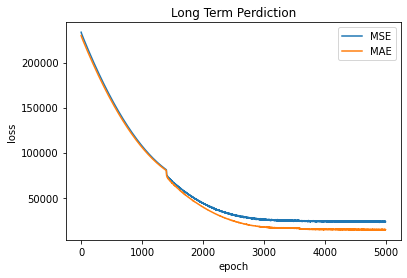

In [ ]:
plt.plot(ltm_history.history['loss'])
plt.plot(ltm_history.history['val_loss'])
plt.title('Long Term Perdiction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE', 'MAE'], loc='upper right')
plt.show()

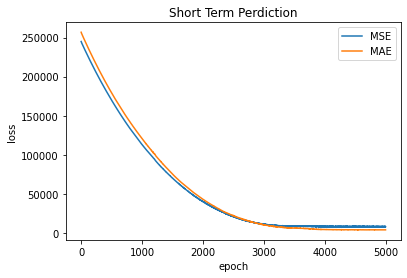

In [ ]:
plt.plot(stm_history.history['loss'])
plt.plot(stm_history.history['val_loss'])
plt.title('Short Term Perdiction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE', 'MAE'], loc='upper right')
plt.show()

### **Experiment 7**

In [ ]:
activation = tf.nn.tanh
k_init = 'normal'
optimizer = 'adam'
neurons=30
batch_size = 256
ltm_epochs = 5000
stm_epochs = 5000
test_size = 0.5
k=3
ltm_history, ltm_test_loss = ltm_testing(data, activation, k_init, neurons, optimizer, batch_size, ltm_epochs, test_size)
stm_history, stm_test_loss = stm_testing(data, activation, k_init, neurons, optimizer, batch_size, stm_epochs, test_size, k)

Streaming output truncated to the last 5000 lines.
102/102 [==============================] - 1s 5ms/step - loss: 8566.6755 - mean_absolute_error: 64.3529 - root_mean_squared_error: 92.5415 - val_loss: 4963.3232 - val_mean_absolute_error: 56.2710 - val_root_mean_squared_error: 70.4509
Epoch 2502/5000
102/102 [==============================] - 1s 6ms/step - loss: 8446.4990 - mean_absolute_error: 63.5656 - root_mean_squared_error: 91.9030 - val_loss: 5022.4624 - val_mean_absolute_error: 56.6937 - val_root_mean_squared_error: 70.8693
Epoch 2503/5000
102/102 [==============================] - 0s 4ms/step - loss: 8572.0669 - mean_absolute_error: 64.7984 - root_mean_squared_error: 92.5789 - val_loss: 4996.4448 - val_mean_absolute_error: 56.3662 - val_root_mean_squared_error: 70.6855
Epoch 2504/5000
102/102 [==============================] - 1s 5ms/step - loss: 8124.3735 - mean_absolute_error: 63.3618 - root_mean_squared_error: 90.1286 - val_loss: 5039.6895 - val_mean_absolute_error: 56.7028 

In [ ]:
print(ltm_test_loss)
print(stm_test_loss)

[14615.3564453125, 93.6823501586914, 120.89398956298828]
[1203.657958984375, 23.922958374023438, 34.69377517700195]


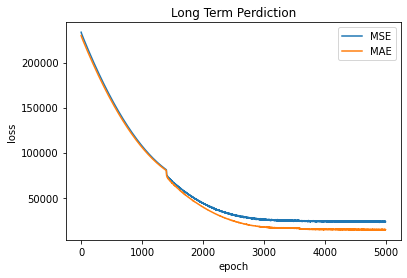

In [ ]:
plt.plot(ltm_history.history['loss'])
plt.plot(ltm_history.history['val_loss'])
plt.title('Long Term Perdiction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE', 'MAE'], loc='upper right')
plt.show()

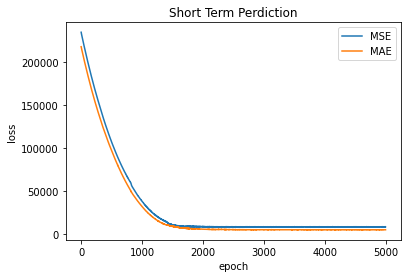

In [ ]:
plt.plot(stm_history.history['loss'])
plt.plot(stm_history.history['val_loss'])
plt.title('Short Term Perdiction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE', 'MAE'], loc='upper right')
plt.show()

## **Graphical Representations**

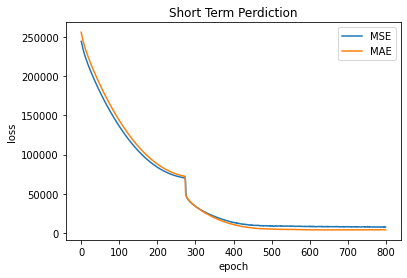

In [ ]:
plt.plot(stm_history.history['loss'])
plt.plot(stm_history.history['val_loss'])
plt.title('Short Term Perdiction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE', 'MAE'], loc='upper right')
plt.show()

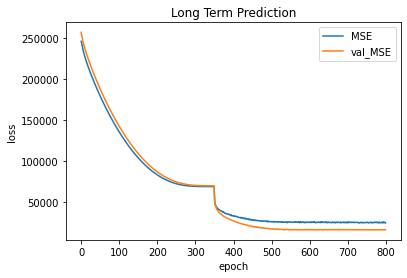

In [ ]:
plt.plot(ltm_history.history['loss'])
plt.plot(ltm_history.history['val_loss'])
plt.title('Long Term Prediction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE', 'val_MSE'], loc='upper right')
plt.show()

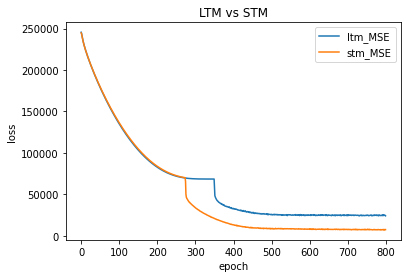

In [ ]:
plt.plot(ltm_history.history['loss'])
plt.plot(stm_history.history['loss'])
plt.title('LTM vs STM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ltm_MSE', 'stm_MSE'], loc='upper right')
plt.show()

**For plotting Image 5 of report**

In [ ]:
#from keras.utils import plot_model
#import pydot_ng as pydot

#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
#from IPython.display import Image
#Image(retina=True, filename='model.png')